# Final Project (Depth of King Rook Solution) (Chess)

### Load Libraries

In [1]:
import scipy.io as sio
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from IPython.display import Markdown as md

c:\python36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# heatmap function
def draw_heatmap_linear(acc, acc_desc, param_list):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=param_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(ylabel='parameter')
    plt.title(acc_desc + ' w.r.t parameter')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()

### Load Chess dataset

In [3]:
attr = np.loadtxt('krkopt.data', delimiter=',', usecols=np.arange(0,6), dtype=object)
categ = np.loadtxt('krkopt.data', delimiter=',', usecols=(6), dtype=object)
print(attr.shape)
print(categ.shape)

# change attr values to numerical
attr0 = [ord(val)-96 for val in attr[:,0]]
attr1 = attr[:,1]
attr2 = [ord(val)-96 for val in attr[:,2]]
attr3 = attr[:,3]
attr4 = [ord(val)-96 for val in attr[:,4]]
attr5 = attr[:,5]
attr = np.vstack((attr0, attr1, attr2, attr3, attr4, attr5)).T

# change categ to binary (chance to win in less than thirteen steps)
neg = ['draw', 'sixteen', 'fifteen', 'fourteen', 'thirteen']
new_categ = [(0 if val in neg  else 1) for val in categ]
categ = np.array(new_categ)

print(attr.shape)
print(categ.shape)
print(np.sum(categ))

(28056, 6)
(28056,)
(28056, 6)
(28056,)
13957


In [4]:
# create shuffled dataset
def shuffle_data(attr, categ):
    # creates 3 shuffled sets of 20-20, 50-50, 80-20
    curr_set = {'twenty':{'train':{},'test':{}},'fifty':{'train':{},'test':{}},'eighty':{'train':{},'test':{}}}
    
    # index shuffling
    set_l = 28056
    ind_ord = np.arange(0,set_l)
    np.random.shuffle(ind_ord)
    
    # 20%-80%
    curr_set['twenty']['train'] = {'type':categ[ind_ord[:int(set_l*.2)]], 'feat':attr[ind_ord[:int(set_l*.2)],:]}
    curr_set['twenty']['test'] = {'type':categ[ind_ord[int(set_l*.2):]], 'feat':attr[ind_ord[int(set_l*.2):],:]}

    # 50%-50%
    curr_set['fifty']['train'] = {'type':categ[ind_ord[:int(set_l*.5)]], 'feat':attr[ind_ord[:int(set_l*.5)],:]}
    curr_set['fifty']['test'] = {'type':categ[ind_ord[int(set_l*.5):]], 'feat':attr[ind_ord[int(set_l*.5):],:]}

    # 80%-20%
    curr_set['eighty']['train'] = {'type':categ[ind_ord[:int(set_l*.8)]], 'feat':attr[ind_ord[:int(set_l*.8)],:]}
    curr_set['eighty']['test'] = {'type':categ[ind_ord[int(set_l*.8):]], 'feat':attr[ind_ord[int(set_l*.8):],:]}
    
    return curr_set

### Boosted Trees (BST-DT)

In [30]:
# set prep (cars)
chess_sets = shuffle_data(attr, categ)
sets = [];
sets.append(chess_sets['twenty']);
sets.append(chess_sets['fifty']);
sets.append(chess_sets['eighty']);
desc = ['20-80', '50-50', '80-20']

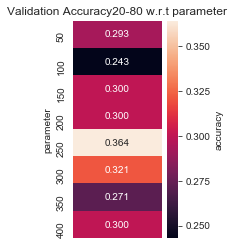

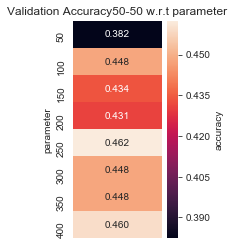

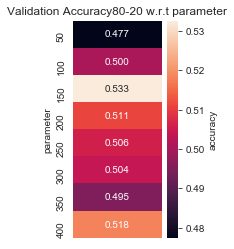

Wall time: 2min 44s


In [32]:
%%time
# Hyper-Parameter Selection: max number of estimators
clf = ensemble.AdaBoostRegressor(tree.DecisionTreeRegressor())
n_estimators = [50, 100, 150, 200, 250, 300, 350, 400]

gridsearch = GridSearchCV(clf, {'n_estimators': n_estimators}, cv = 5)

# reduce setsize for gridsearch by 10%
setr = []
for seti in sets:
    seti_l = int(len(seti['train']['type'])*.1)
    seti_l2 = int(len(seti['test']['type'])*.1)
    tempset = {'train': { 'feat': seti['train']['feat'][:seti_l,:],
                        'type': seti['train']['type'][:seti_l]},
               'test': { 'feat': seti['test']['feat'][:seti_l2,:],
                        'type': seti['test']['type'][:seti_l2]}}
    setr.append(tempset)

counter = 0
for seti in setr:
    gridsearch.fit(seti['train']['feat'], seti['train']['type'].ravel())
    val_acc = np.array(gridsearch.cv_results_['mean_test_score'])
    
    draw_heatmap_linear(val_acc.reshape(8,1), 'Validation Accuracy'+desc[counter], n_estimators)
    counter+=1

In [33]:
%%time
best_n_estimator = [250, 250, 150]
best_val_acc = [0, 0, 0]
best_train_acc = [0, 0, 0]
best_test_acc = [0, 0, 0]

num_trials = 3
for trial in range(num_trials):
    counter = 0
    
    # reshuffle data
    chess_sets = shuffle_data(attr, categ)
    sets = [];
    sets.append(chess_sets['twenty']);
    sets.append(chess_sets['fifty']);
    sets.append(chess_sets['eighty']);
    
    for seti in sets:
        clf = ensemble.AdaBoostRegressor(tree.DecisionTreeRegressor(), n_estimators = best_n_estimator[counter])
        scores = cross_validate(clf, seti['train']['feat'], seti['train']['type'].ravel(), cv=5)
        train_acc = np.mean(scores['train_score'])
        val_acc = np.mean(scores['test_score'])
        fitting = clf.fit(seti['train']['feat'], seti['train']['type'].ravel())
        test_acc = fitting.score(seti['test']['feat'], seti['test']['type'].ravel())
        best_train_acc[counter] += train_acc/num_trials
        best_val_acc[counter] += val_acc/num_trials
        best_test_acc[counter] += test_acc/num_trials
        counter +=1

c:\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score (

Wall time: 9min 50s


In [34]:
# generate latex table
table = '\\begin{tabular}{|c | c c c |}\n'
table += '\\hline\n'
table += '& 20\%-80\% & 50\%-50\% & 80\%-20\%\\\\\n\\hline\\\n'
table += 'Max Estimators & $'+'$ & $'.join('%.3f'%x for x in best_n_estimator) + '$\\\\\n'
table += 'Training Accuracy & $'+'$ & $'.join('%.3f'%x for x in best_train_acc) + '$\\\\\n'
table += 'Validation Accuracy & $'+'$ & $'.join('%.3f'%x for x in best_val_acc) + '$\\\\\n'
table += 'Testing Accuracy & $'+'$ & $'.join('%.3f'%x for x in best_test_acc) + '$\\\\\n\\hline\n'
table += '\\end{tabular}'
print(table)

\begin{tabular}{|c | c c c |}
\hline
& 20\%-80\% & 50\%-50\% & 80\%-20\%\\
\hline\
Max Estimators & $250.000$ & $250.000$ & $150.000$\\
Training Accuracy & $1.000$ & $1.000$ & $1.000$\\
Validation Accuracy & $0.693$ & $0.830$ & $0.890$\\
Testing Accuracy & $0.713$ & $0.858$ & $0.920$\\
\hline
\end{tabular}


![(ACC) for (BST-DT) on Chess](table10.svg)

### Support Vector Machine (SVM)

In [5]:
# set prep (cars)
chess_sets = shuffle_data(attr, categ)
sets = [];
sets.append(chess_sets['twenty']);
sets.append(chess_sets['fifty']);
sets.append(chess_sets['eighty']);
desc = ['20-80', '50-50', '80-20']

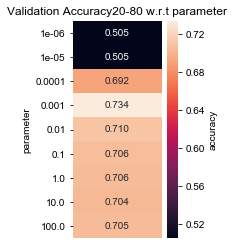

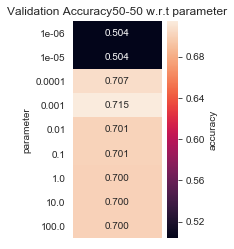

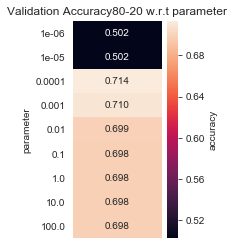

Wall time: 1h 2min 33s


In [6]:
%%time
# Hyper-Parameter Selection: regularization
clf = svm.SVC(kernel='linear')
# regularization = [10e-7, 10e-6, 10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 10e0, 10e1, 10e2, 10e3]
regularization = [10e-7, 10e-6, 10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 10e0, 10e1]

gridsearch = GridSearchCV(clf, {'C': regularization}, cv = 3)
    
counter = 0
for seti in sets:
    gridsearch.fit(seti['train']['feat'], seti['train']['type'].ravel())
    val_acc = np.array(gridsearch.cv_results_['mean_test_score'])
    
    draw_heatmap_linear(val_acc.reshape(9,1), 'Validation Accuracy'+desc[counter], regularization)
    counter+=1

In [7]:
%%time
best_regularizer = [.001, .001, .0001]
best_val_acc = [0, 0, 0]
best_train_acc = [0, 0, 0]
best_test_acc = [0, 0, 0]

num_trials = 3
for trial in range(num_trials):
    counter = 0
    
    # reshuffle data
    chess_sets = shuffle_data(attr, categ)
    sets = [];
    sets.append(chess_sets['twenty']);
    sets.append(chess_sets['fifty']);
    sets.append(chess_sets['eighty']);
    
    for seti in sets:
        clf = svm.SVC(kernel='linear', C=best_regularizer[counter])
        scores = cross_validate(clf, seti['train']['feat'], seti['train']['type'].ravel(), cv=5)
        train_acc = np.mean(scores['train_score'])
        val_acc = np.mean(scores['test_score'])
        fitting = clf.fit(seti['train']['feat'], seti['train']['type'].ravel())
        test_acc = fitting.score(seti['test']['feat'], seti['test']['type'].ravel())
        best_train_acc[counter] += train_acc/num_trials
        best_val_acc[counter] += val_acc/num_trials
        best_test_acc[counter] += test_acc/num_trials
        counter +=1

c:\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score (

Wall time: 7min 32s


In [9]:
# generate latex table
table = '\\begin{tabular}{| c | c c c |}\n'
table += '\\hline\n'
table += '& 20\%-80\% & 50\%-50\% & 80\%-20\%\\\\\n\\hline\n'
table += 'Best Regularizer & $'+'$ & $'.join('%.3f'%x for x in best_regularizer) + '$\\\\\n'
table += 'Training Accuracy & $'+'$ & $'.join('%.3f'%x for x in best_train_acc) + '$\\\\\n'
table += 'Validation Accuracy & $'+'$ & $'.join('%.3f'%x for x in best_val_acc) + '$\\\\\n'
table += 'Testing Accuracy & $'+'$ & $'.join('%.3f'%x for x in best_test_acc) + '$\\\\\n\\hline\n'
table += '\\end{tabular}'
print(table)

\begin{tabular}{| c | c c c |}
\hline
& 20\%-80\% & 50\%-50\% & 80\%-20\%\\
\hline
Best Regularizer & $0.001$ & $0.001$ & $0.000$\\
Training Accuracy & $0.725$ & $0.716$ & $0.722$\\
Validation Accuracy & $0.725$ & $0.716$ & $0.721$\\
Testing Accuracy & $0.724$ & $0.711$ & $0.724$\\
\hline
\end{tabular}


![(ACC) for (SVM) on Chess](table11a.svg)

### K Nearest Neighbors (KNN)

In [12]:
# set prep (cars)
chess_sets = shuffle_data(attr, categ)
sets = [];
sets.append(chess_sets['twenty']);
sets.append(chess_sets['fifty']);
sets.append(chess_sets['eighty']);
desc = ['20-80', '50-50', '80-20']

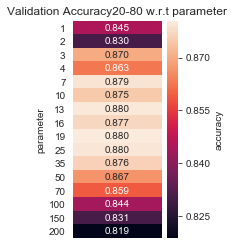

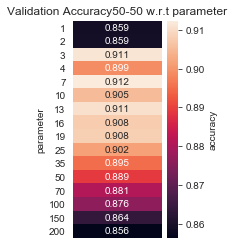

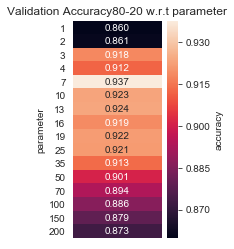

Wall time: 4min 58s


In [14]:
%%time
# Hyper-Parameter Selection: number of neighbors
clf = neighbors.KNeighborsClassifier()
n_neighbors = [1, 2, 3, 4, 7, 10, 13, 16, 19, 25, 35, 50, 70, 100, 150, 200]

counter = 0;
for seti in sets:
    
    gridsearch = GridSearchCV(clf, {'n_neighbors': n_neighbors}, cv = 5)
    
    gridsearch.fit(seti['train']['feat'], seti['train']['type'].ravel())
    val_acc = np.array(gridsearch.cv_results_['mean_test_score'])
    
    draw_heatmap_linear(val_acc.reshape(16,1), 'Validation Accuracy'+desc[counter], n_neighbors)
    counter+=1

In [15]:
%%time
best_k = [13, 7, 7]
best_val_acc = [0, 0, 0]
best_train_acc = [0, 0, 0]
best_test_acc = [0, 0, 0]

num_trials = 3
for trial in range(num_trials):
    counter = 0
    
    # reshuffle data
    chess_sets = shuffle_data(attr, categ)
    sets = [];
    sets.append(chess_sets['twenty']);
    sets.append(chess_sets['fifty']);
    sets.append(chess_sets['eighty']);
    
    for seti in sets:
        clf = neighbors.KNeighborsClassifier(n_neighbors=best_k[counter])
        scores = cross_validate(clf, seti['train']['feat'], seti['train']['type'].ravel(), cv=5)
        train_acc = np.mean(scores['train_score'])
        val_acc = np.mean(scores['test_score'])
        fitting = clf.fit(seti['train']['feat'], seti['train']['type'].ravel())
        test_acc = fitting.score(seti['test']['feat'], seti['test']['type'].ravel())
        best_train_acc[counter] += train_acc/num_trials
        best_val_acc[counter] += val_acc/num_trials
        best_test_acc[counter] += test_acc/num_trials
        counter +=1

c:\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score (

Wall time: 38.5 s


In [16]:
# generate latex table
table = '\\begin{tabular}{| c | c c c |}\n'
table += '\\hline\n'
table += '& 20\%-80\% & 50\%-50\% & 80\%-20\%\\\\\n\\hline\n'
table += 'Best K Neighbors & $'+'$ & $'.join('%.3f'%x for x in best_k) + '$\\\\\n'
table += 'Training Accuracy & $'+'$ & $'.join('%.3f'%x for x in best_train_acc) + '$\\\\\n'
table += 'Validation Accuracy & $'+'$ & $'.join('%.3f'%x for x in best_val_acc) + '$\\\\\n'
table += 'Testing Accuracy & $'+'$ & $'.join('%.3f'%x for x in best_test_acc) + '$\\\\\n\\hline\n'
table += '\\end{tabular}'
print(table)

\begin{tabular}{| c | c c c |}
\hline
& 20\%-80\% & 50\%-50\% & 80\%-20\%\\
\hline
Best K Neighbors & $13.000$ & $7.000$ & $7.000$\\
Training Accuracy & $0.905$ & $0.948$ & $0.969$\\
Validation Accuracy & $0.877$ & $0.909$ & $0.937$\\
Testing Accuracy & $0.885$ & $0.923$ & $0.955$\\
\hline
\end{tabular}


![(ACC) for (KNN) on Chess](table12.svg)